In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


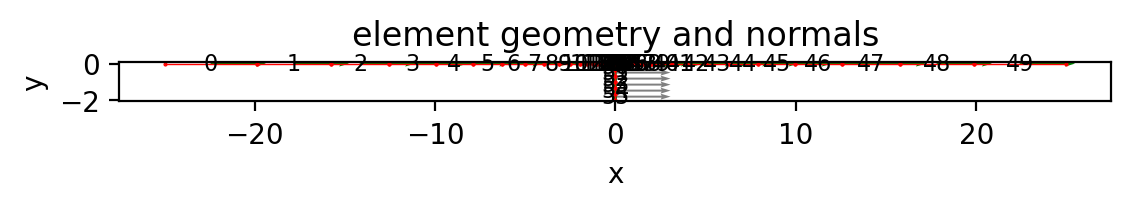

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# Create fault and topography mesh
# create a mesh of topography
topo_n = 50  # only even number
topo_L = 50  # topo extent in x from [-L/2,L/2]
topo_amp = 0  # amplitude of topography as a Gaussian
topo_sigma = 1  # spread of Gaussian topography

xlogvals = np.logspace(-1.0, np.log10(topo_L / 2), int(topo_n / 2))
xmesh = np.concatenate((-xlogvals[::-1], [0.0], xlogvals))
xt1 = xmesh[0:-1]
xt2 = xmesh[1:]
yt1 = topo_amp * np.exp(-(xt1**2) / 2 / (topo_sigma**2))
yt2 = topo_amp * np.exp(-(xt2**2) / 2 / (topo_sigma**2))

# create a mesh of a dipping fault intersecting the free surface
fault_n = 6
slipvalues_y = -np.array([1, 1, 1.0, 0.9, 0.4, 0.1])
slipvalues_x = np.zeros(fault_n)

fault_L = 2.0
fault_dip = 90 * np.pi / 180
# Sinusoidal y-positions for fault elements
# xlocs = np.linspace(0, fault_L * np.cos(fault_dip), fault_n + 1)
# ylocs = -(np.linspace(0, fault_L * np.sin(fault_dip), fault_n + 1))
xlocs = np.zeros(fault_n + 1)
ylocs = -(np.linspace(0, fault_L, fault_n + 1))

# Wavy fault geometry
xf1 = xlocs[0:-1]
xf2 = xlocs[1:]
yf1 = ylocs[0:-1]
yf2 = ylocs[1:]

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = np.concatenate([xt1, xf1])
els.y1 = np.concatenate([yt1, yf1])
els.x2 = np.concatenate([xt2, xf2])
els.y2 = np.concatenate([yt2, yf2])
bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [3]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 3
: [array([0]), array([167]), array([149])]
Number of 2-overlap nodes = 53
: [array([ 3, -2]), array([ 6, -5]), array([ 9, -8]), array([ 12, -11]), array([ 15, -14]), array([ 18, -17]), array([ 21, -20]), array([ 24, -23]), array([ 27, -26]), array([ 30, -29]), array([ 33, -32]), array([ 36, -35]), array([ 39, -38]), array([ 42, -41]), array([ 45, -44]), array([ 48, -47]), array([ 51, -50]), array([ 54, -53]), array([ 57, -56]), array([ 60, -59]), array([ 63, -62]), array([ 66, -65]), array([ 69, -68]), array([ 72, -71]), array([ 165, -164]), array([ 162, -161]), array([ 159, -158]), array([ 156, -155]), array([ 153, -152]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([ 96, -95]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 120, -119]), array([ 123, -122]), array([ 126, -125]), ar

In [4]:
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Boundary conditions are
# topography - traction-free (tx,ty) = (0,0)
# fault mesh - specified slip values
bc_x = np.zeros((n_els, 1))
bc_y = np.zeros((n_els, 1))
# logical index for topography mesh in 'els'
topo_index = np.zeros(n_els, dtype=bool)
topo_index[0:topo_n] = True

bc_x[topo_index, 0] = 0.0
bc_y[topo_index, 0] = 0.0
bc_x[~topo_index, 0] = slipvalues_x
bc_y[~topo_index, 0] = slipvalues_y

BC_c[0::2] = bc_x
BC_c[1::2] = bc_y
# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

## Design Matrix System 
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness

We first deal with the matrix system for the central nodes

In [5]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(els)

# Patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# x-kernels
kerneleval_x[topo_index, 0::6] = traction_kernels_s[0][topo_index, 0::3]
kerneleval_x[topo_index, 1::6] = traction_kernels_s[0][topo_index, 1::3]
kerneleval_x[topo_index, 2::6] = traction_kernels_s[0][topo_index, 2::3]
kerneleval_x[topo_index, 3::6] = traction_kernels_n[0][topo_index, 0::3]
kerneleval_x[topo_index, 4::6] = traction_kernels_n[0][topo_index, 1::3]
kerneleval_x[topo_index, 5::6] = traction_kernels_n[0][topo_index, 2::3]
kerneleval_x[~topo_index, :] = matrix_slip[2::6, :][~topo_index, :]

# y-kernels
kerneleval_y[topo_index, 0::6] = traction_kernels_s[1][topo_index, 0::3]
kerneleval_y[topo_index, 1::6] = traction_kernels_s[1][topo_index, 1::3]
kerneleval_y[topo_index, 2::6] = traction_kernels_s[1][topo_index, 2::3]
kerneleval_y[topo_index, 3::6] = traction_kernels_n[1][topo_index, 0::3]
kerneleval_y[topo_index, 4::6] = traction_kernels_n[1][topo_index, 1::3]
kerneleval_y[topo_index, 5::6] = traction_kernels_n[1][topo_index, 2::3]
kerneleval_y[~topo_index, :] = matrix_slip[3::6, :][~topo_index, :]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

/Users/mallick/Documents/GitHub/bemcs/bemcs/bemcs.py:145: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/mallick/Documents/GitHub/bemcs/bemcs/bemcs.py:146: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))


### Open nodes, overlapping nodes & triple junctions

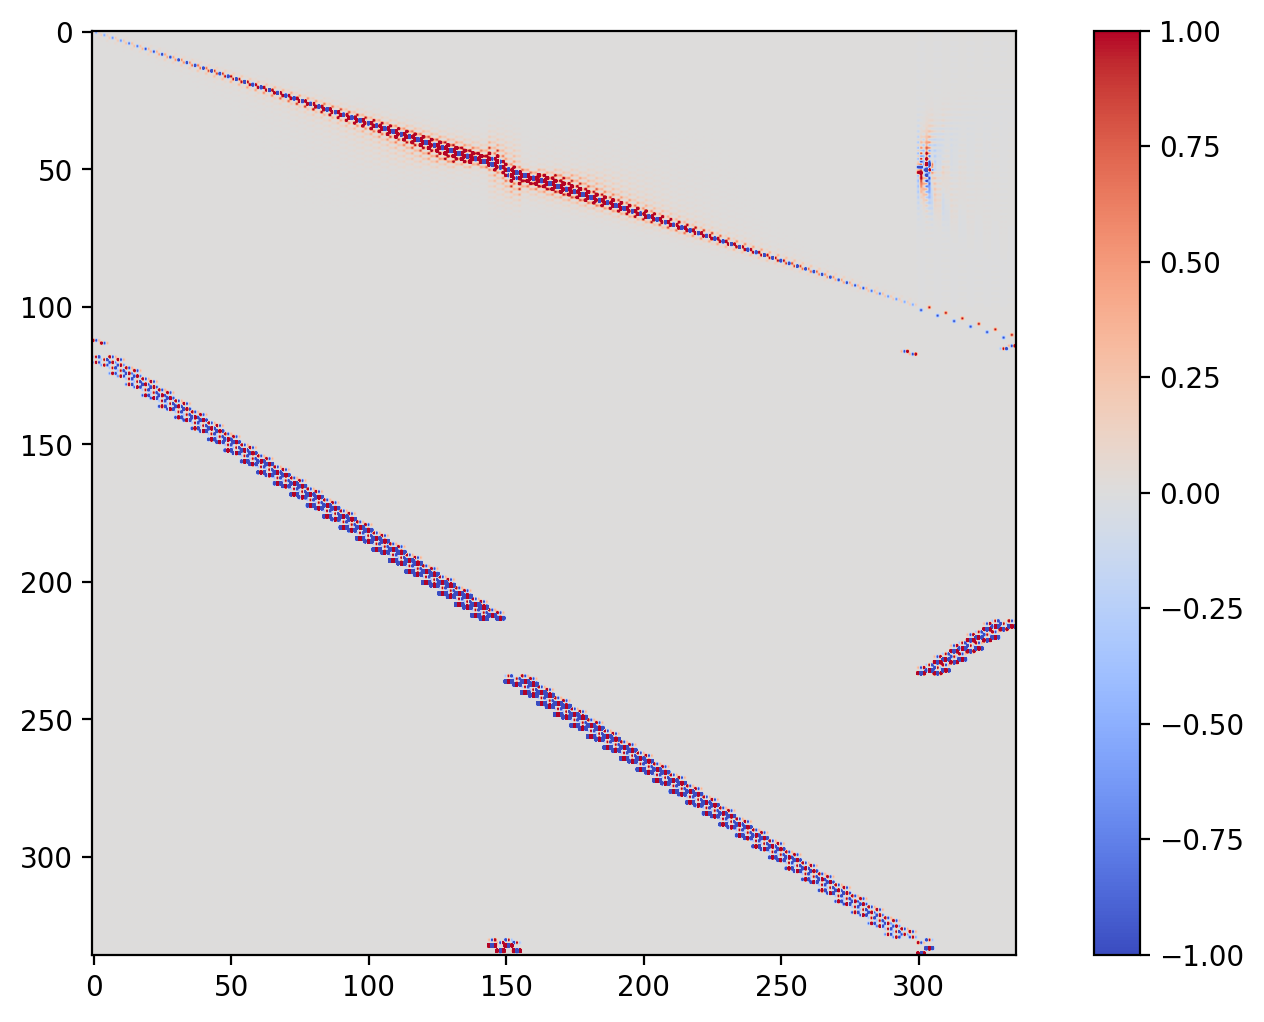

In [6]:
matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(10, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

# Solve system

In [7]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 58790.798997387035


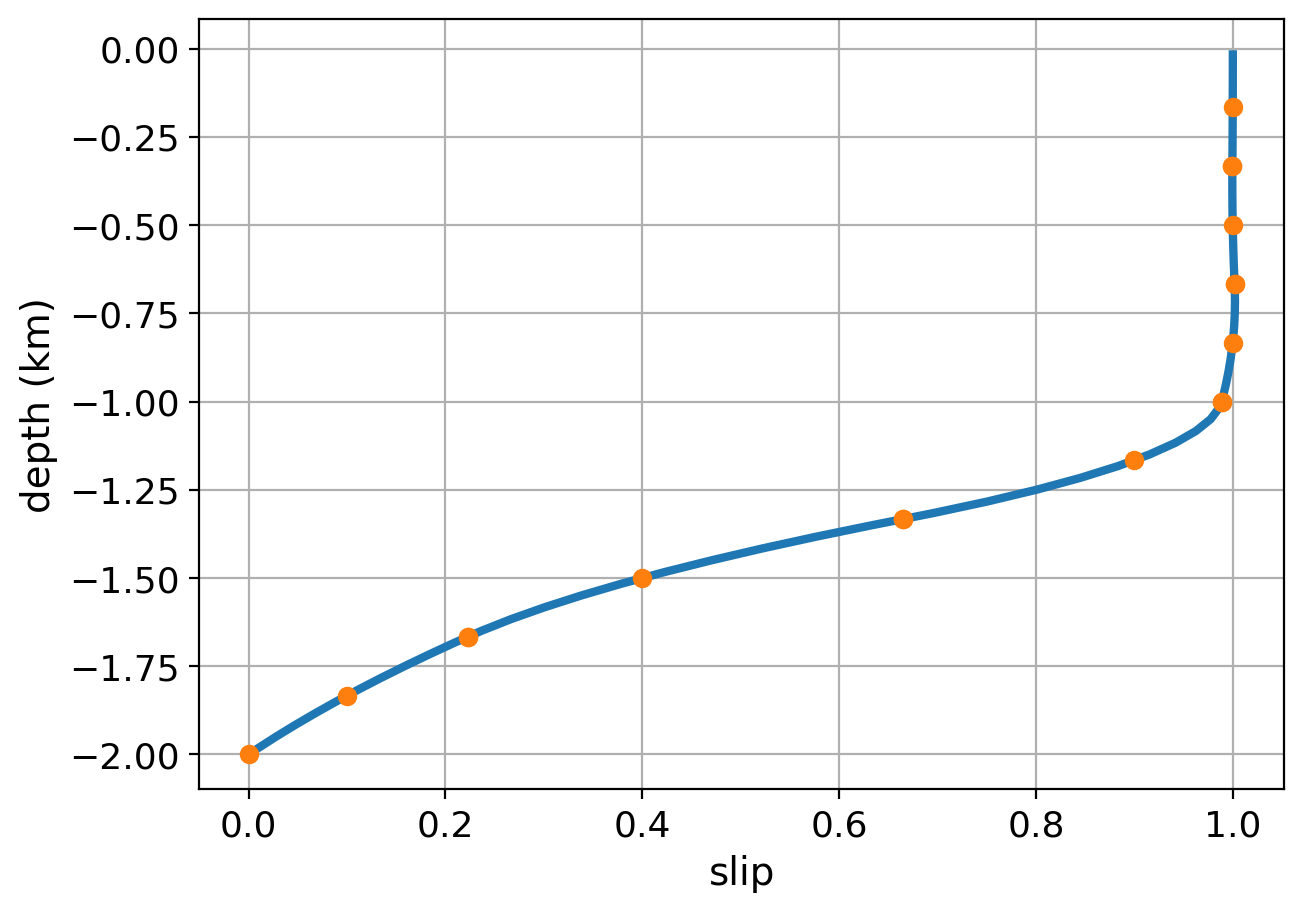

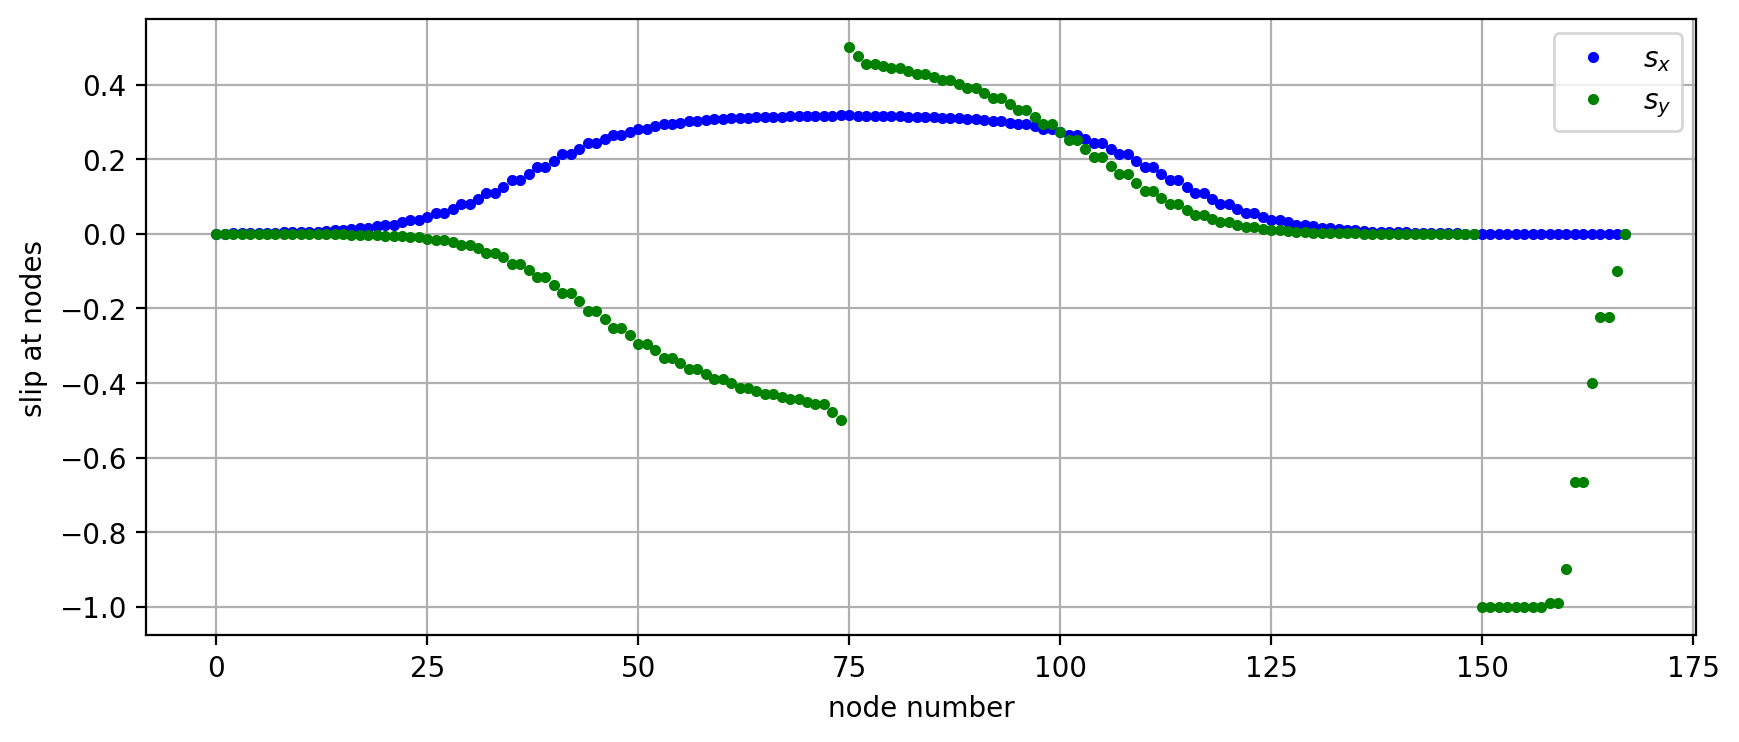

In [8]:
# plot slip distribution on fault source
xnodes, ynodes, sx, sy = bemcs.get_slipvector_on_fault(
    els, quadratic_coefs.flatten(), 10
)

index = (ynodes < 0) | (xnodes == 0)


plt.figure(figsize=(7, 5))
plt.plot(np.abs(sy[index]), ynodes[index], "-", linewidth=3)

ynodes = np.zeros((n_els * 3))
xnodes = np.zeros((n_els * 3))

ynodes[0::3] = els.y1
ynodes[1::3] = els.y_centers
ynodes[2::3] = els.y2
xnodes[0::3] = els.x1
xnodes[1::3] = els.x_centers
xnodes[2::3] = els.x2
index = ynodes < 0  # & (xnodes == 0)
plt.plot(np.abs((matrix_slip @ quadratic_coefs)[1::2])[index], ynodes[index], "o")
# plt.ylim([-3, 0])
plt.xlabel("slip", fontsize=14)
plt.ylabel("depth (km)", fontsize=14)
plt.tick_params(labelsize=13)
plt.grid()
plt.show()

# Extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))

# Rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3 * n_els, 1))
slip_nodes_n = np.zeros((3 * n_els, 1))

for i in range(n_els):
    dummy = slip_vector[3 * i : 3 * (i + 1), :] @ els.rot_mats[i, :, :]
    slip_nodes_s[3 * i : 3 * (i + 1), 0] = dummy[:, 0]
    slip_nodes_n[3 * i : 3 * (i + 1), 0] = dummy[:, 1]

plt.figure(figsize=(10, 4))
plt.plot(slip_nodes_x, "b.", label="$s_x$")
plt.plot(slip_nodes_y, "g.", label="$s_y$")
plt.xlabel("node number")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()
plt.show()

# slip_nodes_s + quadratic_coefs

## Plot displacement and stress components in the medium

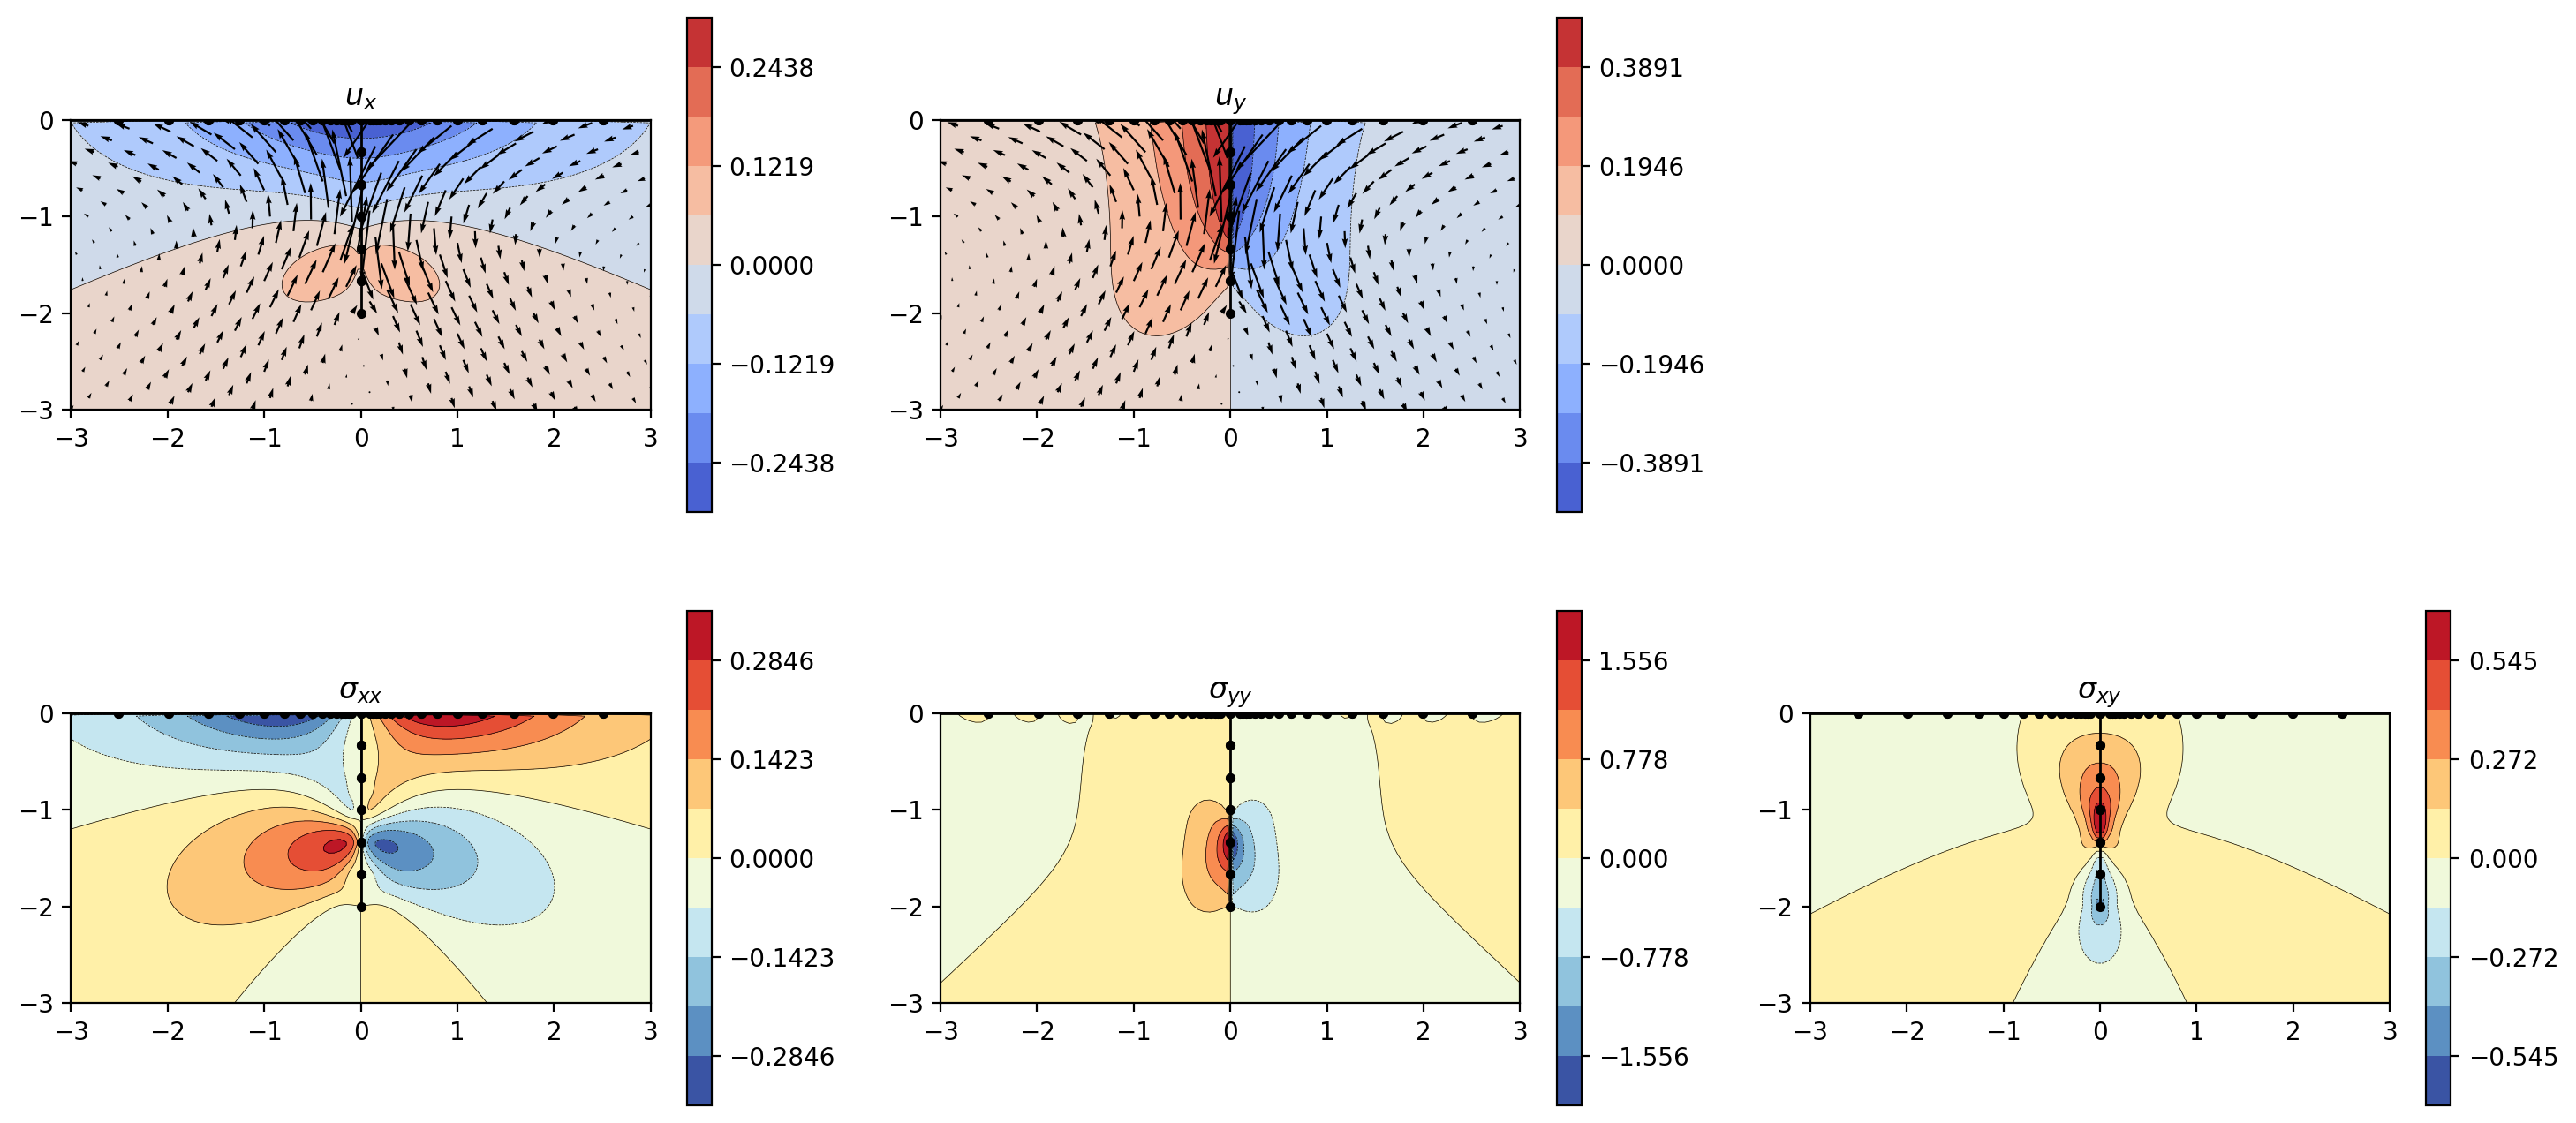

In [9]:
# Observation points
n_obs = 100
width = 3
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width, 0, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=31
)

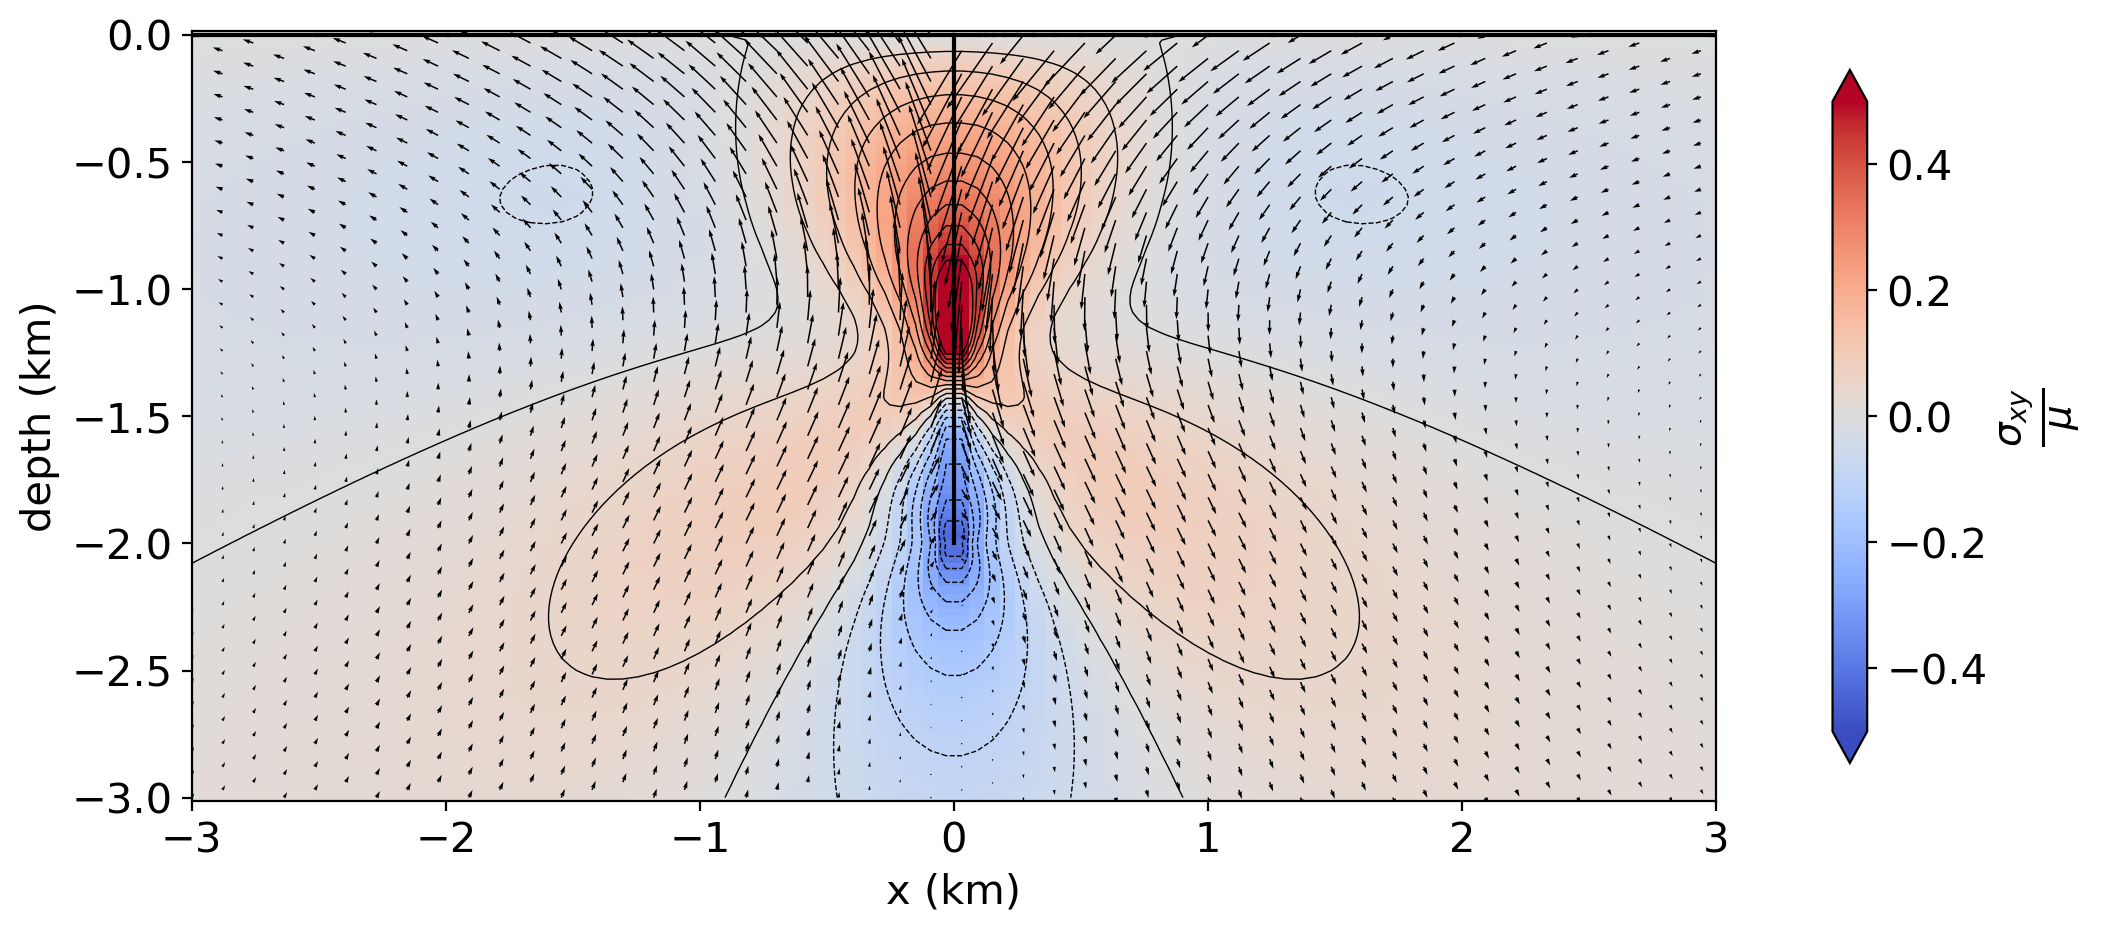

In [10]:
# make a nice plot
toplot = sxy.reshape(n_obs, n_obs)
maxval = 0.5  # np.max(np.abs(toplot))
minval = -maxval
levels = np.linspace(minval, maxval, 21)

plt.figure(figsize=(15, 5))
n_skip_plot = 6
img = plt.pcolor(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="coolwarm",
)
plt.clim([minval, maxval])
cb = plt.colorbar(img, shrink=0.9, extend="both")
cb.ax.tick_params(labelsize=15)
cb.set_label("$\\frac{\sigma_{xy}}{\mu}$", fontsize=20)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.5,
    colors="k",
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.quiver(
    x_obs[0::n_skip_plot],
    y_obs[0::n_skip_plot],
    ux[0::n_skip_plot],
    uy[0::n_skip_plot],
    width=0.001,
    scale=10,
)
plt.xlim([-3, 3])
plt.xlabel("x (km)", fontsize=15)
plt.ylabel("depth (km)", fontsize=15)
plt.tick_params(labelsize=15)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()